In [1]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from sklearn.model_selection import train_test_split
from utils.dataset import Dataset


from utils.preprocessing import *
import core.config as conf

## Load data 

In [2]:
# train_data_path = conf.dataset_path + 'part-210204-2'
train_data_path = conf.raw_lzo_path + 'part-00000'
train_df = read_data(train_data_path)

In [5]:
train_df.head()

,text_tokens,hashtags,tweet_id,media,links,domains,tweet_type,language,tweet_timestamp,creator_id,...,engager_id,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follows_engager,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
0,101\t56898\t137\t16925\t10731\t11481\t13980\t1...,NaN,5DCE3020423313CB0AC2631DEF94D2F5,NaN,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1613237034,BC9980C5385A68894C2862F41884FB27,...,2AEB7AFFD36CA43C0C963F24F75BCCAC,169,339,False,1520886748,False,NaN,NaN,NaN,NaN
1,101\t10159\t11322\t58550\t10836\t10126\t25900\...,NaN,2B6F5C7C4F04F34543C09DD6E58C8F66,NaN,2886BC98B8B910E86A792E56681FC841,9EFF000CDB18B710CDDB43EE1D8C300B,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1613748600,C0EBA033A5C0D2AD91B4500958E2C633,...,865C52D28FA84E5E233B530C6FDAECC2,393,1190,False,1237570695,False,NaN,NaN,NaN,NaN
2,101\t10159\t56314\t14364\t10109\t14657\t11359\...,NaN,784D3AE5E6429392245BD34FF4C82B5C,NaN,B8FEE70DF7DA75C584F9DA8C38E99874,D56FA7843AF6F2BC53A2E192B542EA58,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1613386238,03EA05E7440140ABF047BC216CE34917,...,FE83E568BD4B2ACDBAF876CFBB6C7296,629,1473,False,1263176351,False,NaN,NaN,NaN,1.613388e+09
3,101\t56898\t137\t10224\t10731\t64194\t41939\t3...,NaN,CA49ACBB31921F2A0FAC1CCCC99541F6,NaN,NaN,NaN,Retweet,B0FA488F2911701DD8EC5B1EA5E322D8,1613708640,2700B9E175757F126C082D6A5742787D,...,DB0201BF93E4CCA1B55932AC36923E43,123,200,False,1268276559,False,NaN,NaN,NaN,NaN
4,101\t7143\t1938\t113\t100\t10097\t100\t10097\t...,NaN,2C95B42C651B36D84584F3653D722142,Photo,NaN,NaN,TopLevel,E7F038DE3EAD397AEC9193686C911677,1612586018,B7E441F2D886830FB3F0CE29CB35CB6B,...,04F45C4A769FE2D7C792A96C92342DC2,134,379,False,1483862063,True,NaN,NaN,NaN,1.612587e+09


In [3]:
# val_data_path = conf.dataset_path + 'part-210205-2'
val_data_path = conf.raw_lzo_path + 'part-00001'
val_df = read_data(val_data_path)

In [4]:
train_df.columns

Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'tweet_type', 'language', 'tweet_timestamp', 'creator_id',
       'creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_account_creation', 'engager_id',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_account_creation',
       'creator_follows_engager', 'reply_timestamp', 'retweet_timestamp',
       'comment_timestamp', 'like_timestamp'],
      dtype='object')

## Parameters

In [5]:
MODEL_NAME = 'autoencoder_test'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

## Preprocessing

### dataset preprocess

In [6]:
ds = Dataset(train=True, target_encoding=False)
train_df = ds.preprocess(train_df)
val_df = ds.preprocess(val_df)

### negative samping

In [11]:
train_df

,engager_is_verified,media,creator_follows_engager,creator_id,engager_account_creation,creator_follower_count,engager_id,language,creator_following_count,tweet_id,...,tweet_type,tweet_timestamp,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,0,0,0,BC9980C5385A68894C2862F41884FB27,1520886748,2473,2AEB7AFFD36CA43C0C963F24F75BCCAC,19,662,5DCE3020423313CB0AC2631DEF94D2F5,...,1,1613237034,0.0,0.0,0.0,0.0,13,5,17,0
1,0,0,0,C0EBA033A5C0D2AD91B4500958E2C633,1237570695,4418640,865C52D28FA84E5E233B530C6FDAECC2,46,228,2B6F5C7C4F04F34543C09DD6E58C8F66,...,2,1613748600,0.0,0.0,0.0,0.0,19,4,15,1
2,0,0,0,03EA05E7440140ABF047BC216CE34917,1263176351,219715,FE83E568BD4B2ACDBAF876CFBB6C7296,46,3685,784D3AE5E6429392245BD34FF4C82B5C,...,2,1613386238,0.0,0.0,0.0,1.0,15,0,10,1
3,0,0,0,2700B9E175757F126C082D6A5742787D,1268276559,2388283,DB0201BF93E4CCA1B55932AC36923E43,46,13511,CA49ACBB31921F2A0FAC1CCCC99541F6,...,1,1613708640,0.0,0.0,0.0,0.0,19,4,4,0
4,0,5,1,B7E441F2D886830FB3F0CE29CB35CB6B,1483862063,414,04F45C4A769FE2D7C792A96C92342DC2,61,720,2C95B42C651B36D84584F3653D722142,...,2,1612586018,0.0,0.0,0.0,1.0,6,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,0,0,1,D61350A37DDC6E19AD5B1D44C607FF7D,1505241576,2230,AB51B05ACD422823A8567E51D106FBCF,48,2332,25B1D557E6B6D7298CA3888C72F9F7B5,...,1,1612804061,0.0,0.0,0.0,0.0,8,0,17,0
3033898,0,9,0,9009A33FB64F15F71D689C46FD40DA0E,1587168543,90842,2F0B0497A2C1F6DBF120782E915B1F63,19,687,3A656480D09FCCBA39B0E28FBFA64B72,...,2,1613964078,1.0,0.0,0.0,0.0,22,0,3,0
3033899,0,0,1,57F1EBC5767EA3F7CE3EEDB6EAE9B097,1336720553,608,5FFAD564CE93396A11C7951AA07D019E,19,328,E236B2359B119B2A7668FA83AC5E750B,...,1,1614124187,0.0,0.0,0.0,0.0,23,1,23,0
3033900,0,0,0,D3D9F1F6F4CCFA079891511B0818FF03,1540658011,6777417,1C3C0C32D7AEBCA253DC54EC85084951,46,888,B42CB5B47ABCCA8700686CD8F32696B6,...,2,1613329929,0.0,0.0,0.0,1.0,14,6,19,0


In [12]:
train_df_positive = train_df[train_df['like']==1]
train_df_negative = train_df[train_df['like']==0]
print(len(train_df_positive))
print(len(train_df_negative))

# train_df_positive = train_df_positive.sample(n = len(train_df_negative))
train_df_negative = train_df_negative.sample(n = len(train_df_positive))
train_df = pd.concat([train_df_positive, train_df_negative])

1207588
1826314


In [7]:
train_df.head()


,creator_follows_engager,creator_following_count,language,creator_is_verified,creator_follower_count,media,creator_account_creation,domains,tweet_timestamp,engager_follower_count,...,engager_id,engager_account_creation,reply,retweet,comment,like,dt_day,dt_dow,dt_hour,len_domains
0,0,662,19,0,2473,0,1261859734,0,1613237034,169,...,2AEB7AFFD36CA43C0C963F24F75BCCAC,1520886748,0.0,0.0,0.0,0.0,13,5,17,0
1,0,228,46,1,4418640,0,1266804490,1,1613748600,393,...,865C52D28FA84E5E233B530C6FDAECC2,1237570695,0.0,0.0,0.0,0.0,19,4,15,1
2,0,3685,46,1,219715,0,1202617218,2,1613386238,629,...,FE83E568BD4B2ACDBAF876CFBB6C7296,1263176351,0.0,0.0,0.0,1.0,15,0,10,1
3,0,13511,46,1,2388283,0,1251645191,0,1613708640,123,...,DB0201BF93E4CCA1B55932AC36923E43,1268276559,0.0,0.0,0.0,0.0,19,4,4,0
4,1,720,61,0,414,5,1578273274,0,1612586018,134,...,04F45C4A769FE2D7C792A96C92342DC2,1483862063,0.0,0.0,0.0,1.0,6,5,4,0


In [8]:
train_df.columns

Index(['creator_follows_engager', 'creator_following_count', 'language',
       'creator_is_verified', 'creator_follower_count', 'media',
       'creator_account_creation', 'domains', 'tweet_timestamp',
       'engager_follower_count', 'engager_following_count', 'creator_id',
       'tweet_id', 'tweet_type', 'engager_is_verified', 'engager_id',
       'engager_account_creation', 'reply', 'retweet', 'comment', 'like',
       'dt_day', 'dt_dow', 'dt_hour', 'len_domains'],
      dtype='object')

In [9]:
conf.target

['reply', 'retweet', 'comment', 'like']

In [10]:
used_features = ['engager_follower_count', 
                'engager_following_count', 
                'engager_is_verified', 
                'engager_account_creation', 
                'creator_follower_count', 
                'creator_following_count', 
                'creator_is_verified', 
                'creator_account_creation',
                'media',
                'domains',
                'language',
                'dt_day', 
                'dt_dow', 
                'dt_hour', 
                'len_domains']

In [11]:
X_train = train_df[used_features]
# Y_train = train_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)
Y_train = train_df['like']

In [12]:
X_val = val_df[used_features]
# Y_val = val_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0) 
Y_val = val_df['like']

In [13]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)


### scaling


In [14]:
def scaling(df_x):
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(df_x.values)
    ss = standard_scaler.transform(df_x.values)
    df_x = pd.DataFrame(ss, columns = df_x.columns)
    return df_x

In [15]:
X_train = scaling(X_train)
X_val = scaling(X_val)
X_test = scaling(X_test)

In [16]:
X_train

,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follower_count,creator_following_count,creator_is_verified,creator_account_creation,media,domains,language,dt_day,dt_dow,dt_hour,len_domains
0,-0.064095,-0.219199,-0.040756,0.367779,-0.168589,-0.089206,-0.473566,-1.348970,-0.735590,-0.158524,-0.738195,-0.166146,1.018298,0.748638,-0.338471
1,-0.041385,0.289623,-0.040756,-2.145428,0.823654,-0.102284,2.111640,-1.310229,-0.735590,-0.158272,0.695442,0.823981,0.517806,0.453273,2.577894
2,-0.017458,0.458831,-0.040756,-1.918288,-0.119778,0.001890,2.111640,-1.813128,-0.735590,-0.158021,0.695442,0.163896,-1.484162,-0.285140,2.577894
3,-0.068758,-0.302309,-0.040756,-1.873046,0.367465,0.297992,2.111640,-1.429000,-0.735590,-0.158524,0.695442,0.823981,0.517806,-1.171236,-0.338471
4,-0.067643,-0.195283,-0.040756,0.039344,-0.169051,-0.087458,-0.473566,1.130091,0.838429,-0.158524,1.491906,-1.321293,1.018298,-1.171236,-0.338471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033897,-0.055477,-0.217405,-0.040756,0.228995,-0.168643,-0.038882,-0.473566,1.007225,-0.735590,-0.158524,0.801637,-0.991251,-1.484162,0.748638,-0.338471
3033898,-0.057099,-0.116358,-0.040756,0.955743,-0.148734,-0.088453,-0.473566,1.236818,2.097645,-0.158524,-0.738195,1.319044,-1.484162,-1.318919,-0.338471
3033899,0.001298,0.058231,-0.040756,-1.265901,-0.169008,-0.099271,-0.473566,-0.724812,-0.735590,-0.158524,-0.738195,1.484065,-0.983670,1.634733,-0.338471
3033900,-0.078491,-0.372264,-0.040756,0.543163,1.353634,-0.082396,2.111640,-1.333880,-0.735590,-0.158524,0.695442,-0.001125,1.518790,1.044003,-0.338471


## Model

In [107]:

kargs = {
    'model_name': 'auto_encoder',
    'input_dim' : X_train.shape[1],
    # 'input_dim': 100000,
    'engager_dim' : 4,
    'creator_dim' : 4,
    'embedding_dim': 4,
    'encoder_dim': 64,
    'decoder_dim': 1
    
}


In [122]:
class AutoEncoder(tf.keras.models.Model):
    def __init__(self, **kargs):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = kargs['input_dim']
        self.engager_dim = kargs['engager_dim']
        self.creator_dim = kargs['creator_dim']
        self.embedding_dim = kargs['embedding_dim']
        self.encoder_dim = kargs['encoder_dim']
        self.decoder_dim = kargs['decoder_dim']
        
        self.engager_embedding = tf.keras.layers.Embedding(input_dim=self.engager_dim, output_dim=self.embedding_dim)
        self.creator_embedding = tf.keras.layers.Embedding(input_dim=self.creator_dim, output_dim=self.embedding_dim)
        self.engager_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.creator_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.tweet_encoder = tf.keras.layers.Dense(16, activation = 'relu')
        self.encoder = tf.keras.layers.Dense(8, activation = 'relu')
        # self.encoder2 = tf.keras.layers.Dense(4, activation = 'relu')
        self.decoder = tf.keras.layers.Dense(1, activation = 'relu')
    
    def call(self, x):
        # x1 = self.engager_embedding(x[:,:4])
        # x2 = self.creator_embedding(x[:,4:])
        x1 = self.engager_encoder(x[:,:4])
        x2 = self.creator_encoder(x[:,4:8])


        x3 = self.tweet_encoder(x[:,8:])
        x = tf.concat([x1, x2, x3], 1)
        x = self.encoder(x)
        # x = tf.concat([x, x3], 1)
        # x = self.encoder2(x)
        x = self.decoder(x)
        return x

    def summary(self):
        inputs = tf.keras.layers.Input((self.input_dim))
        tf.keras.models.Model(inputs, self.call(inputs)).summary()
    

In [123]:
model = AutoEncoder(**kargs)


In [124]:
model.summary()
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer = 'adam', # adam
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy'])

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_86 (Sl (None, 4)            0           input_24[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_87 (Sl (None, 4)            0           input_24[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_88 (Sl (None, 7)            0           input_24[0][0]                   
___________________________________________________________________________________________

In [125]:
result = model.fit(
    x = X_train.to_numpy(),
    y = Y_train.to_numpy(),
    validation_data=(X_val.to_numpy(), Y_val.to_numpy()),
    epochs=10,
    batch_size=32
)

Epoch 1/10
 4476/94810 [>.............................] - ETA: 33s - loss: 0.8580 - binary_crossentropy: 0.8580

KeyboardInterrupt: 

## Evaluate

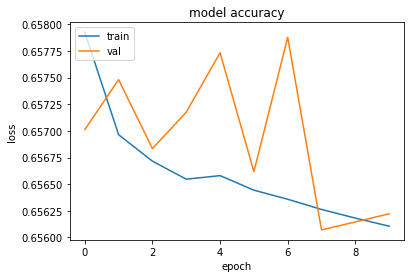

In [46]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [47]:
pred = model.predict(X_test)

In [26]:
pred.reshape(-1)

array([0.3435491 , 0.18260452, 0.5140403 , ..., 0.41026342, 0.34507674,
       0.39101815], dtype=float32)

In [48]:
rce = compute_rce(pred.astype(np.float64), Y_test.astype(np.float64))
rce

2.397426021654314

In [28]:
average_precision_score(Y_test, pred)

0.5039735929674103